In [8]:
# 재시작 없이 import 파일 자동 적용
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pickle
import numpy as np
import pandas as pd
from scipy import interpolate
import neurokit2 as nk
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import h5py
import matplotlib.pyplot as plt

# Data Loading

In [35]:
with h5py.File("./dataset/KMedicon/features.h5", 'r') as f:
# with h5py.File("./dataset/features.h5", 'r') as f:
    ecg = f['ecg'][:]
    label = f['label'][:]

In [36]:
# resampling to 250Hz
def resampling(array, freq, kind='linear'):
    t = np.linspace(1, len(array), len(array))
    f = interpolate.interp1d(t, array, kind=kind)
    t_new = np.linspace(1, len(array), int(len(array)/freq * 250))
    new_array = f(t_new)
    return new_array


# standard normalization 
def normalize(data):
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(data)
    return data_norm


# function of R peaks of a resampled trial
def R_Peaks(ecg_data):
    # get R Peak positions
    pos = []
    # get R Peak intervals
    trial_interval = []
    for ch in range(ecg_data.shape[1]):
        cleaned_ecg = nk.ecg_clean(ecg_data[:, ch], sampling_rate=250, method='neurokit')
        signals, info = nk.ecg_peaks(cleaned_ecg, sampling_rate=250, correct_artifacts=False)
        peaks = signals[signals['ECG_R_Peaks']==1].index.to_list()
        pos.append(peaks)
        channel_interval = []
        for i in range(len(peaks)-1):
            channel_interval.append(peaks[i+1] - peaks[i])
        trial_interval.append(channel_interval)
        
    df_peaks = pd.DataFrame(pos) # [C=15, num of the R-Peaks of a channel]
    df = pd.DataFrame(trial_interval).T
    med = df.median()
    return df, med, df_peaks

In [37]:
ecg.shape

(2400, 5000, 12)

In [38]:
ecg[0].shape

(5000, 12)

In [34]:
cnt = 0
p_ecg = []

for ecg_data in tqdm(ecg):
    sub = []
    trial = []
    for ch in range(ecg_data.shape[1]):
        data = resampling(ecg_data[:,ch], freq=500, kind='linear')
        trial.append(data)
        
    trial = np.array(trial).T
    sub.append(trial)

    sub = np.array(sub)
    sub = sub.reshape(-1, 2500, sub.shape[-1])

    p_ecg.append(sub)

    cnt +=1

100%|██████████| 2400/2400 [00:05<00:00, 439.89it/s]

(1, 2500, 12)


In [35]:
np.array(p_ecg).shape

(2400, 1, 2500, 12)

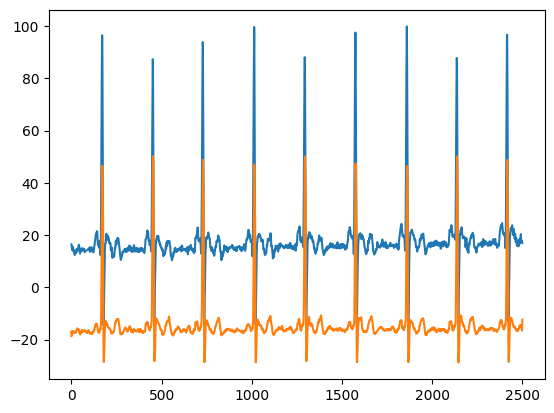

In [67]:
import matplotlib.pyplot as plt

plt.plot(sub[0][:,0])
plt.plot(sub[0][:,-1])
plt.show()

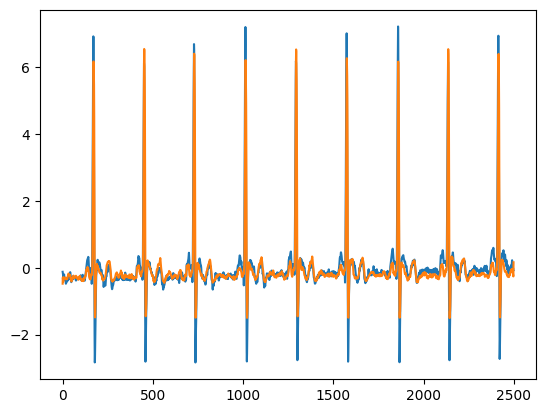

In [83]:
a = sub[0][:,0]
b = sub[0][:,-1]

a = (a-a.mean()) / a.std()
b = (b-b.mean()) / b.std()
plt.plot(a)
plt.plot(b)
plt.show()

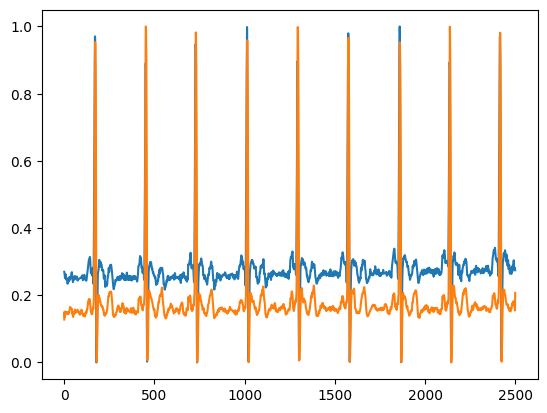

In [87]:
a = sub[0][:,0]
b = sub[0][:,-1]

a = (a-a.min()) / (a.max() - a.min())
b = (b-b.min()) /(b.max() - b.min())
plt.plot(a)
plt.plot(b)
plt.show()

In [27]:
# with h5py.File("./dataset/KMedicon/processed_features_500.h5", 'w') as f:
with h5py.File("./dataset/processed_features_norm.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(label))
    # f.create_dataset('custom_label', data=custom_label)

# pkl to h5

In [14]:
with open("./dataset/KMedicon/Target_Train.pkl", 'rb') as f:
    signal = pickle.load(f)
  
# label  
# df = pd.read_csv("./label/public_test_label.csv")
# df = pd.read_excel("./label/public_test_label.xlsx")

In [19]:
signal.Target.values

array([0., 0., 1., ..., 0., 0., 0.])

In [4]:
test_signal = np.array(signal)

label = np.array(df['label'].to_list())

In [5]:
cnt = 0
p_ecg = []

for ecg_data in tqdm(test_signal):
    sub = []
    trial = []
    for ch in range(ecg_data.shape[1]):
        # data = resampling(ecg_data[:,ch], freq=500, kind='linear')
        data = ecg_data[:, ch]
        trial.append(data)
        
    trial = np.array(trial).T
    # trial_norm = normalize(trial)
    sub.append(trial)

    sub = np.array(sub)
    sub = sub.reshape(-1, 5000, sub.shape[-1])  # split 10s trial into 1s sample
    
    p_ecg.append(sub)
    # np.save('./dataset/KMedicon/Feature/feature_{}.npy'.format(cnt), sub)

    cnt +=1

print(sub.shape)

100%|██████████| 300/300 [00:00<00:00, 8504.04it/s]

(1, 5000, 12)


In [6]:
np.array(p_ecg).shape

(300, 1, 5000, 12)

In [7]:
# with h5py.File("./dataset/KMedicon/public_test2.h5", 'w') as f:
with h5py.File("./dataset/public_test.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(label))

# CONCAT

In [39]:
def z_score_normalization(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    normalized_signal = (signal - mean) / std_dev
    return normalized_signal

In [50]:
signals = []

for i in tqdm(range(ecg.shape[0])):
    normalized_array1 = [z_score_normalization(resampling(ecg[i, :, l], freq=500, kind='linear')) for l in range(0, 6)]
    normalized_array2 = [z_score_normalization(resampling(ecg[i, :, l], freq=500, kind='linear')) for l in range(6, 12)]
    
    normalized_array1 = np.concatenate(np.array(normalized_array1))
    normalized_array2 = np.concatenate(np.array(normalized_array2))
    
    signal = np.stack((normalized_array1, normalized_array2), axis=1)
    
    signals.append(signal)

100%|██████████| 2400/2400 [00:06<00:00, 351.43it/s]


In [57]:
signals = np.array(signals)
signals.shape

(2400, 15000, 2)

In [61]:
with h5py.File("./dataset/features_concat.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(signals))
    f.create_dataset('label', data=np.array(label))